# Trenowanie i porównanie modeli

## TODO
* Model neuronowy
* Imputacja brakujących wartości
* Selekcja atrybutów

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from scipy.stats import truncnorm
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR

## Model bazowy

* Za model bazowy przyjmujemy model losowy z rozkładem normalnym o parametrach takich jak rozkład w zbiorze treningowym
  * Średnia:  4.77
  * Odchylenie standardowe: 0.27
  * Obcięty do [0, 5]

(0.0, 5.0)

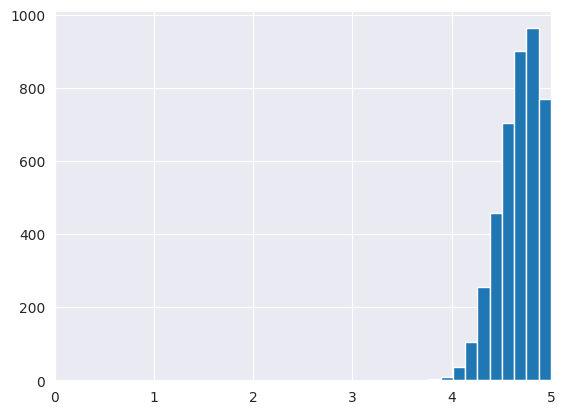

In [2]:
def base_model(size: int, mean, std, lower, upper) -> np.ndarray:
    a = (lower - mean) / std
    b = (upper - mean) / std
    return truncnorm.rvs(a, b, loc=mean, scale=std, size=size)


sample = base_model(4200, 4.77, 0.27, 0, 5)
plt.hist(sample)
plt.xlim(0, 5)

## Dane
Wczytanie przetworzonych danych

In [3]:
listings = pd.read_csv('../data/processed/listings.csv')
listings = listings.dropna(subset=["avg_rating"])

In [4]:
len(listings)

3223

In [5]:
listings["avg_rating"].describe()

count    3223.000000
mean        4.768786
std         0.274342
min         0.714286
25%         4.705714
50%         4.838571
75%         4.920000
max         5.000000
Name: avg_rating, dtype: float64

(0.0, 5.0)

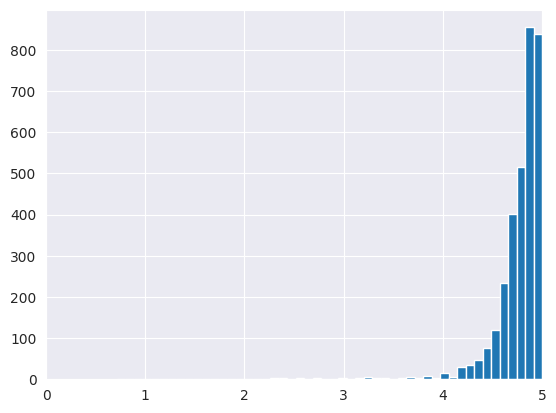

In [6]:
plt.hist(listings["avg_rating"], bins=50)
plt.xlim(0, 5)

## Porównanie modeli

In [7]:
y = listings["avg_rating"]
X = listings.drop(columns=["avg_rating"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
def display_summary(model_name, y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("-" * 30)
    print(model_name)
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"R-squared: {r2:.2f}")

In [9]:
def drop_missing_values(X_train, X_test, y_train, y_test):
    # Drop missing values
    X_train = X_train.dropna()
    y_train = y_train[X_train.index]
    X_test = X_test.dropna()
    y_test = y_test[X_test.index]
    return X_train, X_test, y_train, y_test

In [10]:
def bench_linear_regression(X_train, X_test, y_train, y_test):
    X_train, X_test, y_train, y_test = drop_missing_values(X_train, X_test, y_train, y_test)

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    display_summary("Linear regression", y_test, y_pred)


In [11]:
def bench_base_model(X_test):
    y_pred = base_model(len(X_test), mean=4.77, std=0.27, lower=0, upper=5)
    display_summary("Base model (Gauss)", y_test, y_pred)

In [12]:
def bench_random_forest(X_train, X_test, y_train, y_test):
    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    display_summary("Random forest", y_test, y_pred)

In [13]:
def bench_svr(X_train, X_test, y_train, y_test):
    X_train, X_test, y_train, y_test = drop_missing_values(X_train, X_test, y_train, y_test)

    model = SVR(kernel="linear")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    display_summary("SVR", y_test, y_pred)

In [14]:
def bench_ridge(X_train, X_test, y_train, y_test):
    X_train, X_test, y_train, y_test = drop_missing_values(X_train, X_test, y_train, y_test)

    model = Ridge()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    display_summary("Ridge", y_test, y_pred)

In [15]:
def bench_lasso(X_train, X_test, y_train, y_test):
    X_train, X_test, y_train, y_test = drop_missing_values(X_train, X_test, y_train, y_test)

    model = Lasso(alpha=0.1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    display_summary("Lasso", y_test, y_pred)

In [16]:
def bench_gradient_boosting(X_train, X_test, y_train, y_test):
    X_train, X_test, y_train, y_test = drop_missing_values(X_train, X_test, y_train, y_test)
    model = GradientBoostingRegressor()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    display_summary("Gradient boosting", y_test, y_pred)

In [17]:
def bench_svr_rbf(X_train, X_test, y_train, y_test):
    X_train, X_test, y_train, y_test = drop_missing_values(X_train, X_test, y_train, y_test)

    model = SVR(kernel="rbf")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    display_summary("SVR (rhf)", y_test, y_pred)

In [18]:
bench_base_model(X_test)
bench_linear_regression(X_train, X_test, y_train, y_test)
bench_random_forest(X_train, X_test, y_train, y_test)
# bench_svr(X_train, X_test, y_train, y_test)
bench_ridge(X_train, X_test, y_train, y_test)
bench_lasso(X_train, X_test, y_train, y_test)
bench_gradient_boosting(X_train, X_test, y_train, y_test)
bench_svr_rbf(X_train, X_test, y_train, y_test)

------------------------------
Base model (Gauss)
Mean Squared Error: 0.13
R-squared: -0.66
------------------------------
Linear regression
Mean Squared Error: 0.11
R-squared: 0.05
------------------------------
Random forest
Mean Squared Error: 0.07
R-squared: 0.06
------------------------------
Ridge
Mean Squared Error: 0.11
R-squared: 0.05
------------------------------
Lasso
Mean Squared Error: 0.12
R-squared: -0.00
------------------------------
Gradient boosting
Mean Squared Error: 0.11
R-squared: 0.09
------------------------------
SVR (rhf)
Mean Squared Error: 0.11
R-squared: 0.06


## Zapis modelu do pliku

In [19]:
model_file = "../models/linear_regression.pkl"

listings = pd.read_csv('../data/processed/listings.csv')
listings = listings.dropna(subset=["avg_rating"])
y = listings["avg_rating"]
X = listings.drop(columns=["avg_rating"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = drop_missing_values(X_train, X_test, y_train, y_test)

model = LinearRegression()
model.fit(X_train, y_train)

with open(model_file, "wb") as f:
    pickle.dump(model, f)